In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, NumbaPerformanceWarning
import scipy

from plot_helpers import plotCoordinateFrame, set_axes_equal
from jacobian import jac
from manifold import K_from_vec, vec_from_K, SE3_from_vec, vec_from_SE3

import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.set_printoptions(suppress=True, precision=3, edgeitems=30, linewidth=100000)

In [2]:
#----------- Projection helpers ----------#
@njit
def h(K, T, P):
    p_homo = K@T@to_homogen(P).T
    return from_homogen(p_homo.T)

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def residuals(K, Ts, Ps, zs):     
    # Compute expected measurements
    l = zs[0].size
    res = np.zeros(l * Ts.shape[0])
    for i, T in enumerate(Ts):
        p_prime = h(K, T, Ps)
        res[i*l:(i+1)*l] = (zs[i] - p_prime).flatten()
    
    return res

In [6]:
def levenburg(residual, K_init, Ts_init, Ps_init, zs, jac, lam=10.0, lam_multiplier=10.0, max_iters=100, tol=1e-8, verbose=False):
    # Loosely adapted from https://github.com/jjhartmann/Levenberg-Marquardt-Algorithm/blob/master/LMA.py
    K = K_init.copy()
    Ts = Ts_init.copy()
    Ps = Ps_init.copy()
    M = Ts.shape[0]
    N = Ps.shape[0]
    
    prev_cost = np.linalg.norm( residual(K, Ts, Ps, zs) )
    I = scipy.sparse.identity(5 + (Ts.shape[0]-1)*6 + Ps.shape[0]*3)
    lam_init = lam
    
    if verbose:
        print(f"Starting cost: {prev_cost}")

    for k in range(max_iters):
        # Make right hand side
        J = jac(K, Ts, Ps)
        JtJ = J.T@J
        
        # Make left hand side
        r = residual(K, Ts, Ps, zs)
        b = J.T@r
            
        # Run with this linearization
        cost = prev_cost + 1
        while cost > prev_cost:
            # Find our delta
            A = JtJ + lam*I
            delta = scipy.sparse.linalg.spsolve(A, b)
            
            # Make copy of current estimate
            Kstar = K.copy()
            Tstar = Ts.copy()
            Pstar = Ps.copy()
            
            # Apply updates
            Kstar = K_from_vec( vec_from_K(K) + delta[:5] )
            for i in range(1,M):
                Tstar[i] = Ts[i]@SE3_from_vec( delta[5+6*(i-1):5+6*i] )
            Pstar += delta[5+6*(M-1):].reshape((N,3))
            
            # See if it got us anywhere
            cost = np.linalg.norm( residual(Kstar, Tstar, Pstar, zs) )
                        
            # If it didn't work, try a smaller step
            if cost > prev_cost:
                lam *= lam_multiplier
                
            if lam > 1e9:
                print("LM failed to converge")
                return K, Ts, Ps
                        
        # If our step worked, increment and keep going
        K = Kstar
        Ts = Tstar
        Ps = Pstar
        
        if lam < lam_init:
            lam *= lam_multiplier
        
        # See if it was a small improvement, and if so, be done
        if np.abs(prev_cost - cost) < tol:
            return K, Ts, Ps
        else:
            prev_cost = cost
            
        if verbose and k % 1 == 0:
            print(f"{k}, \t Cost: {cost} \t Lam: {lam}")
            
    return K, Ts, Ps

### Create fake ground truth data

In [3]:
K_gt = np.array([[1520 ,    0.1  ,  300, 0],
               [   0.  , 1500 ,  250, 0],
               [   0.  ,    0.  ,    1., 0]])

# Make P the 2 sides of a box
num = 30
x = np.linspace(0,2,num)
y = np.linspace(-1,1,num)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = -X + 5
P1 = np.column_stack((X,Y,Z))

x = np.linspace(-2,0,num)
y = np.linspace(-1,1,num)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = X + 5
P2 = np.column_stack((X,Y,Z))

P_gt = np.vstack((P1,P2))

# Ground truth poses
T_gt = np.array([
            np.eye(4),
            SE3_from_vec(np.array([.2, -10*np.pi/180, .1, 0.7, 0.3, 0.1])),
            SE3_from_vec(np.array([.2, 10*np.pi/180, .1, -0.7, 0.5, -0.1])),
            SE3_from_vec(np.array([-.5, 0.1, .4, -1, -1.5, -0.4]))
        ])

### Apply noise to data

In [4]:
# Initial guesses
Ps_init = P_gt + np.random.normal(scale=0.3, size=P_gt.shape)
Ts_init = T_gt.copy()
for i in range(1,Ts_init.shape[0]):
    Ts_init[i] = Ts_init[i] @ SE3_from_vec(np.array([*np.random.normal(scale=0.2,size=3), *np.random.normal(scale=0.2,size=3)]))
K_init = K_from_vec( vec_from_K(K_gt) + np.random.normal(scale=5, size=5) )

# Generate data
zs = np.array([h(K_gt, T, P_gt) + np.random.normal(scale=5) for T in T_gt])
# zs = np.array([h(K_gt, T, P_gt) for T in T_gt])

### Run Optimizer

In [10]:
%time K_result, T_result, P_result = levenburg(residuals, K_init, Ts_init, Ps_init, zs, jac, max_iters=100, lam=.001, lam_multiplier=2, verbose=True)
np.linalg.norm(residuals(K_result, T_result, P_result, zs))

Starting cost: 54760.43659149551
0, 	 Cost: 11829.290446778183 	 Lam: 0.001
1, 	 Cost: 2004.5904299942765 	 Lam: 0.001
2, 	 Cost: 1877.7550026206654 	 Lam: 0.001
3, 	 Cost: 209.10279509866984 	 Lam: 0.001
4, 	 Cost: 16.439520403908464 	 Lam: 0.001
5, 	 Cost: 16.436477192536056 	 Lam: 0.001
CPU times: user 4.3 s, sys: 9.93 s, total: 14.2 s
Wall time: 991 ms


16.436477187542504

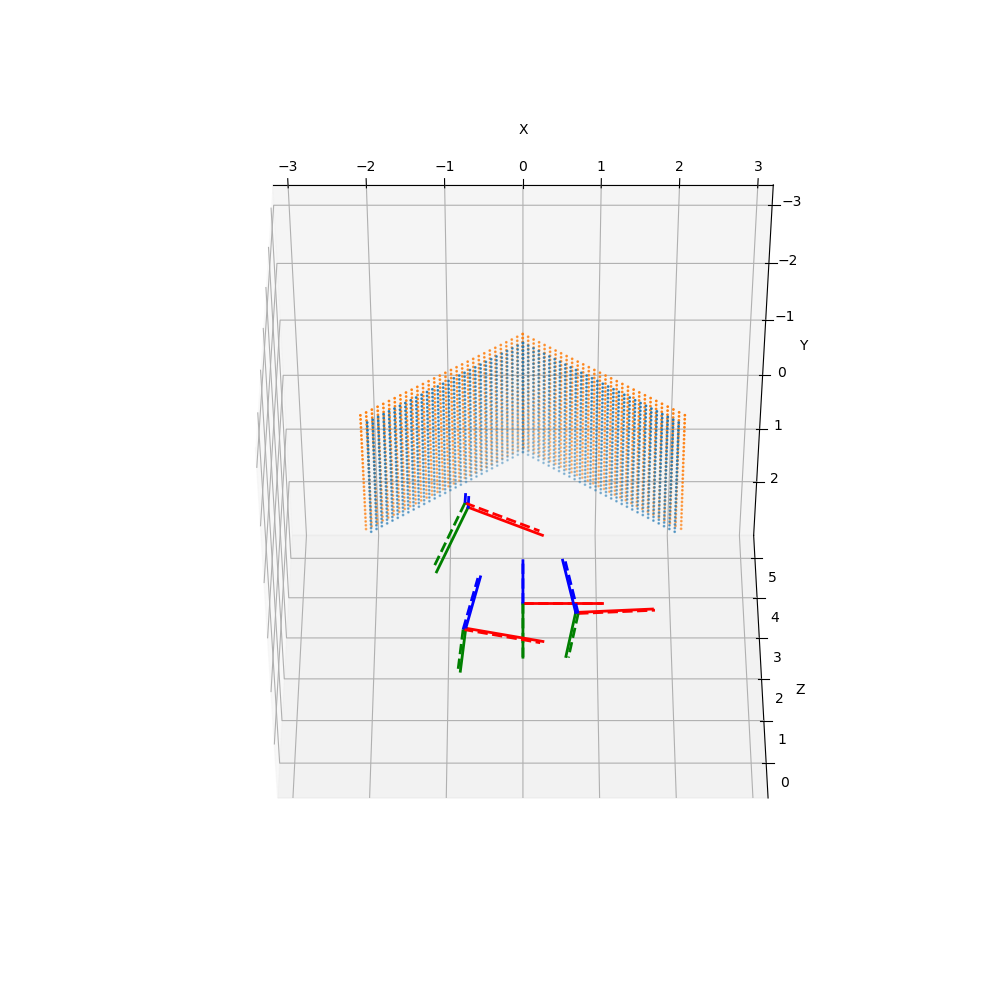

In [8]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P_gt[:,0], P_gt[:,1], P_gt[:,2], s=1)
ax.scatter(P_result[:,0], P_result[:,1], P_result[:,2], s=1)
for T, gt in zip(T_result, T_gt):
    plotCoordinateFrame(gt, ax=ax)
    plotCoordinateFrame(T, ax=ax, k="--")
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, -90)
plt.show()